# Radiomics Model Development

In this notebook we will show you how to compare different classifiers and how to fine-tune and assess your best model.

But first we need check and install any required libraries that may be missing.

## Check Environment and Install required libraries to execute notebooks

In [1]:
!python -c "import sklearn" || pip install --progress-bar off -q scikit-learn
!python -c "import matplotlib" || pip install --progress-bar off -q matplotlib
!python -c "import numpy" || pip install --progress-bar off -q numpy
!python -c "import shap" || pip install --progress-bar off -q shap
!python -c "import pandas" || pip install --progress-bar off -q pandas
!python -c "import gdown" || pip install --progress-bar off -q gdown
!python -c "import mlxtend" || pip install --progress-bar off -q mlxtend

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'mlxtend'


## Import required libraries

In [36]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import (roc_auc_score, f1_score, 
                             cohen_kappa_score, accuracy_score, 
                             balanced_accuracy_score, recall_score, 
                             precision_score, balanced_accuracy_score, 
                             make_scorer, matthews_corrcoef)

from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from sklearn.metrics import confusion_matrix, check_scoring

from sklearn.preprocessing import LabelEncoder

from mlxtend.evaluate import ftest, mcnemar, mcnemar_tables, mcnemar_table
from statsmodels.stats.multitest import multipletests

### Check if needed files exist and download if not available

We will now download 2 files: a file containing the radiomic features and anoter file containing the corresponding labels.


In [3]:
if not os.path.isfile('output_t2w.csv'):
    !gdown --id 1fusKGIfs4EZBYm5h8e9MxtKIt3Puvr6l -q

if not os.path.isfile("PROSTATEx_Classes.csv"):
    !gdown --id 1kxSmF8iRmrLDqxkLvcTVvWPhD9H3tY7n -q

We are going to partially print the labels and features

In [4]:
features_df = pd.read_csv('output_t2w.csv')
outcome_df = pd.read_csv('PROSTATEx_Classes.csv')
display(features_df.head())
display(outcome_df.head())

,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,lbp-2D_gldm_GrayLevelNonUniformity,lbp-2D_gldm_GrayLevelVariance,lbp-2D_gldm_HighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceEmphasis,lbp-2D_gldm_LargeDependenceHighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
0,ProstateX-0000,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,90.435897,1.079131,7.068376,8.584046,51.655271,2.945730,0.342652,0.271247,2.194099,0.093697
1,ProstateX-0001,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,135.386100,1.118901,6.942085,7.934363,48.671815,3.012830,0.368927,0.292795,2.417508,0.098274
2,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,165.913333,0.927322,6.703333,9.453333,53.716667,2.917303,0.328275,0.269131,2.160250,0.092260
3,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,132.917647,1.088904,7.250980,8.015686,54.501961,2.724523,0.340373,0.292592,2.382360,0.098212
4,ProstateX-0003,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,455.010423,1.319275,7.429647,7.213086,51.013897,3.008665,0.389279,0.292029,2.195095,0.106361


,ID,Clinically Significant,Gleason Grade Group
0,ProstateX-0000_Finding1,True,3
1,ProstateX-0001_Finding1,False,1
2,ProstateX-0002_Finding1,True,2
3,ProstateX-0002_Finding2,False,1
4,ProstateX-0003_Finding1,False,No biopsy information


We want to predict the findings' clinical significance and a patient may have more than one lesion.

We will need to be carefull to split our dataset to ensure that we are not leaking data by having different findings of the same patient across different datasets.

To prevent this, and to ensure that we correctly match the findings' clinical significance to the corresponding radiomic features we will need to create some additional columns in the radiomic features and label dataframes.

In [5]:
# create a finding id for the radiomic features dataframe
features_df['FindingID'] = [os.path.basename(x)[:23].replace("-F","_F") for x in features_df['Mask']]

# create a finding id that will store the previous id from the outcome and then 
# update the ID to match to the id of the patient to ensure partition at the 
# patient level
outcome_df['FindingID'] = outcome_df['ID']
outcome_df['ID'] = outcome_df['ID'].str[:14]

## Set the finding as index column to easily merge the radiomics and outcome dataframes

In [6]:
features_df.set_index("FindingID", inplace=True)
outcome_df.set_index("FindingID", inplace=True)
features_outcome_df = pd.concat([outcome_df[["Clinically Significant"]], features_df], axis=1, join="inner")
display(features_outcome_df)

,Clinically Significant,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,lbp-2D_gldm_GrayLevelNonUniformity,lbp-2D_gldm_GrayLevelVariance,lbp-2D_gldm_HighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceEmphasis,lbp-2D_gldm_LargeDependenceHighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
FindingID,,,,,,,,,,,,,,,,,,,,,
ProstateX-0000_Finding1,True,ProstateX-0000,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,90.435897,1.079131,7.068376,8.584046,51.655271,2.945730,0.342652,0.271247,2.194099,0.093697
ProstateX-0001_Finding1,False,ProstateX-0001,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,135.386100,1.118901,6.942085,7.934363,48.671815,3.012830,0.368927,0.292795,2.417508,0.098274
ProstateX-0002_Finding1,True,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,165.913333,0.927322,6.703333,9.453333,53.716667,2.917303,0.328275,0.269131,2.160250,0.092260
ProstateX-0002_Finding2,False,ProstateX-0002,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,132.917647,1.088904,7.250980,8.015686,54.501961,2.724523,0.340373,0.292592,2.382360,0.098212
ProstateX-0003_Finding1,False,ProstateX-0003,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,455.010423,1.319275,7.429647,7.213086,51.013897,3.008665,0.389279,0.292029,2.195095,0.106361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ProstateX-0201_Finding1,True,ProstateX-0201,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,1715.753219,1.247344,7.184366,7.707166,51.173762,3.138016,0.385975,0.278111,2.210073,0.093811
ProstateX-0202_Finding1,True,ProstateX-0202,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,1254.959550,1.258851,7.109883,7.924937,51.534821,3.285643,0.394362,0.273947,2.197806,0.095511
ProstateX-0202_Finding2,False,ProstateX-0202,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,/Users/joaosantinha/CODE/Radiomics/PROSTATEx_m...,v3.0.1,1.24.4,2.3.1,1.4.1,3.8.19,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,97.055096,0.998717,6.611570,9.936639,58.308540,2.987718,0.355257,0.264197,2.031158,0.103273


# Split Data

We will start by splitting the data into 2 separate sets.

1. Training dataset
2. Held-out test dataset

The training dataset will be used for the selection of the classifier algorithm we will use and its fine-tuning, while the held-out test dataset will be used to validade the model and assess its performance on unseen data.

Traditionally, in case the patients would only have one finding we could use the following function to split the data: 
```
test_prcntg = 0.25

random_state_value = 1 # necessary for reproducibility

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_prcntg,random_state=random_state_value, stratify=Y.to_list())
```

### But here because patients can have multiple lesions lets do a trick to create an held-out test datased comprising 25% (0.25)

We first create the group corresponding to the **PatientID**, the outcome *y* corresponding to the clinical significance of the finding, and the input *X* corresponding to the radiomic feature values of the findings

In [7]:
from sklearn.model_selection import StratifiedGroupKFold
y = features_outcome_df["Clinically Significant"]
groups = features_outcome_df.ID
X = features_outcome_df.drop(['Clinically Significant', 'ID', 'Image', 'Mask',
                              'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 
                              'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 
                              'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 
                              'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 
                              'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 
                              'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 
                              'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 
                              'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 
                              'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 
                              'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 
                              'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 
                              'diagnostics_Image-interpolated_Spacing', 'diagnostics_Image-interpolated_Size', 
                              'diagnostics_Image-interpolated_Mean', 'diagnostics_Image-interpolated_Minimum', 
                              'diagnostics_Image-interpolated_Maximum', 'diagnostics_Mask-interpolated_Spacing', 
                              'diagnostics_Mask-interpolated_Size', 'diagnostics_Mask-interpolated_BoundingBox', 
                              'diagnostics_Mask-interpolated_VoxelNum', 'diagnostics_Mask-interpolated_VolumeNum', 
                              'diagnostics_Mask-interpolated_CenterOfMassIndex', 'diagnostics_Mask-interpolated_CenterOfMass', 
                              'diagnostics_Mask-interpolated_Mean', 'diagnostics_Mask-interpolated_Minimum', 
                              'diagnostics_Mask-interpolated_Maximum',], axis=1)

Using the **StratifiedGroupKFold** with `n_splits=4` we can use the first fold to define our Training and Held-out test set with guaranties that no patient findings are present in both dataset and that proportion of clinically significant findings are maintained. 

In [8]:
# define random state variable for reproducibility
random_state_value = 1

print_information = False

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=random_state_value)
sgkf.split(X, y, groups)
train_index, test_index = next(sgkf.split(X, y, groups))
if print_information:
    print(f"  Train: index={train_index}")
    print(f"         size={len(train_index)}")
    print(f"         group={groups[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         size={len(test_index)}")
    print(f"         group={groups[test_index]}")

X_train = X.iloc[train_index]
Y_train = y.iloc[train_index]

X_test = X.iloc[test_index]
Y_test = y.iloc[test_index]

# Transform Clinically Significant labels from True/False to 1/0 using LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.transform(Y_test)

display(X_train)
display(Y_train)
display(y_train)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,lbp-2D_gldm_GrayLevelNonUniformity,lbp-2D_gldm_GrayLevelVariance,lbp-2D_gldm_HighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceEmphasis,lbp-2D_gldm_LargeDependenceHighGrayLevelEmphasis,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,lbp-2D_gldm_LowGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceEmphasis,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
FindingID,,,,,,,,,,,,,,,,,,,,,
ProstateX-0000_Finding1,0.381395,0.274926,5.154447,18.748495,12.528368,14.312233,11.818629,21.633308,358.5600,7.150591,...,90.435897,1.079131,7.068376,8.584046,51.655271,2.945730,0.342652,0.271247,2.194099,0.093697
ProstateX-0001_Finding1,0.720671,0.328547,5.576379,16.972871,15.367498,15.000000,18.000000,19.809089,538.9650,12.231856,...,135.386100,1.118901,6.942085,7.934363,48.671815,3.012830,0.368927,0.292795,2.417508,0.098274
ProstateX-0003_Finding1,0.860427,0.431030,9.756535,22.635417,25.377943,22.641555,24.782252,26.084478,1818.6750,19.476117,...,455.010423,1.319275,7.429647,7.213086,51.013897,3.008665,0.389279,0.292029,2.195095,0.106361
ProstateX-0003_Finding2,0.683300,0.569478,10.117343,17.765995,18.973666,17.492856,19.944924,20.827866,1396.8000,12.139499,...,350.805619,1.341682,7.386484,7.192863,48.501139,3.212789,0.398196,0.288101,2.372246,0.093649
ProstateX-0004_Finding1,0.740195,0.425276,14.609209,34.352264,35.986247,37.206048,32.255232,43.636338,7772.6925,25.427363,...,1275.033849,1.303118,7.310423,7.771930,52.407637,3.315094,0.392818,0.270701,2.184457,0.091820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ProstateX-0201_Finding1,0.871546,0.382889,13.266557,34.648607,33.776323,35.323646,36.840195,42.485762,7075.9350,30.197851,...,1715.753219,1.247344,7.184366,7.707166,51.173762,3.138016,0.385975,0.278111,2.210073,0.093811
ProstateX-0202_Finding1,0.801186,0.602560,15.685827,26.031984,30.558796,26.318055,25.827892,33.136083,5137.8300,20.856453,...,1254.959550,1.258851,7.109883,7.924937,51.534821,3.285643,0.394362,0.273947,2.197806,0.095511
ProstateX-0202_Finding2,0.457748,0.375179,5.822668,15.519716,15.367498,12.924396,9.767292,16.099689,374.4000,7.104114,...,97.055096,0.998717,6.611570,9.936639,58.308540,2.987718,0.355257,0.264197,2.031158,0.103273


FindingID
ProstateX-0000_Finding1     True
ProstateX-0001_Finding1    False
ProstateX-0003_Finding1    False
ProstateX-0003_Finding2    False
ProstateX-0004_Finding1    False
                           ...  
ProstateX-0201_Finding1     True
ProstateX-0202_Finding1     True
ProstateX-0202_Finding2    False
ProstateX-0203_Finding1     True
ProstateX-0203_Finding2     True
Name: Clinically Significant, Length: 230, dtype: bool

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

## Selection of optimization metrics
### A little bit about metrics
Metrics play a very important role in the development and performance of our model. Its the optimization metric that allows us to select the proper classifier among several other options and train/fine-tune the classifier hyper-parameters to obtain our final model.

Different metrics provide different information on the classification performance and may depend on the properties of our dataset (e.g., are the classes in our dataset balanced or not).

In many applications we will deal with unbalanced datasets. In this situation one can either upsample the under-represented class (which has risks due to the generation of data that has not been observed) or downsample the over-represented class (which will discard information that was collected and may be usefull).

Another option is to try to pick a better optimization metric that tries to overcome the unbalance of our dataset.

Accuracy is know to be a bad metric for optimization of classifiers using data with unbalanced classes/outcomes. 

Metrics like F1-score, Balanced Accuracy, Cohen's Kappa and Matthews Correlation Coefficient have been suggested to better deal with unbalanced datasets.

### Select optimization metric

In [9]:
optimization_metric = "AUC" #@param ["AUC", "MCC", "Kappa","F1", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "BalancedAcc"]

if optimization_metric == "AUC":
    score_str = 'roc_auc'
elif optimization_metric == "MCC":
    score_str = make_scorer(matthews_corrcoef)
elif optimization_metric == "Kappa":
    score_str = make_scorer(cohen_kappa_score)
elif optimization_metric == "F1":
    score_str = 'f1'
elif optimization_metric == "Accuracy":
    score_str = 'accuracy'
elif optimization_metric == "Sensitivity":
    score_str = 'recall'
elif optimization_metric == "Specificity":
    score_str = make_scorer(recall_score, pos_label=0)
elif optimization_metric == "PPV":
    score_str = 'precision'
elif optimization_metric == "NPV":
    score_str = make_scorer(precision_score, pos_label=0)
elif optimization_metric == "BalancedAcc":
    score_str = 'balanced_accuracy'

score_group = {'AUC': 'roc_auc', 'MCC': make_scorer(matthews_corrcoef) ,
               'Kappa': make_scorer(cohen_kappa_score), 
               'F1': 'f1', 'Accuracy': 'accuracy', 
               'Sensitivity': 'recall', 
               'Specificity': make_scorer(recall_score, pos_label=0),
               'PPV': 'precision', 
               'NPV': make_scorer(precision_score, pos_label=0),
               'BalancedAcc': 'balanced_accuracy'}

score_refit_str = optimization_metric

## Classifier Selection

When trying to compare and select among several classifiers, the recommended approach select the best classifier method is by using the nested cross-validation. This proceedure consist of an outer k-fold cross-validation loop to splipt the data into training and test folds, and an inner k-fold cross-validation loop on the training fold, as shown the figure below.

![](https://drive.google.com/uc?export=view&id=10IZjGrPq7xBWPslhlNPBqwb-9qx7Mevx)

Below you can select the models to be compared (the more you select the longer the execution time) by setting those to `True`

In [10]:
SVM_classifier = True
LogisticRegression_classifier = True
RandomForest_classifier = True
NaiveBayes_classifier = False
KNN_classifier = False
GradientBoosting_classifier = False

## Run and Compare Classifiers

We do this using nested cross-validation given that we are optimizing the models' hyperparameters and this was we have a less bias estimation of performance compared to a single cross-validation.

In [ ]:
def cross_val_all_scores(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    params=None,
    pre_dispatch="2*n_jobs",
    error_score=np.nan,
):
    
    # To ensure multimetric format is not supported
    scorer = check_scoring(estimator, scoring=scoring)

    cv_results = cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        groups=groups,
        scoring={"score": scorer},
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        fit_params=fit_params,
        params=params,
        pre_dispatch=pre_dispatch,
        error_score=error_score,
    )
    return cv_results["test_score"]

In [52]:
df_ncv_scores = pd.DataFrame(columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
df_ncv_preds = pd.DataFrame(columns = ['Classifier', 'Preds', 'GT'])
if SVM_classifier:
    pipe_svc = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             SVC(random_state=random_state_value, class_weight="balanced"))

    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_grid_svc = [{'svc__C': param_range, 
                  'svc__kernel': ['linear']},
                  {'svc__C': param_range, 
                  'svc__gamma': param_range, 
                  'svc__kernel': ['rbf']}]

    gs_svc = GridSearchCV(estimator=pipe_svc, 
                      param_grid=param_grid_svc, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_scv = cross_val_score(gs_svc, X_train, y_train, 
                            scoring=score_str, cv=5)
    
    preds_svc = cross_val_predict(gs_svc, X_train, y_train, 
                            cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['SVM'], 'Nested-CV Mean': [np.mean(scores_scv)], 'Nested-CV Std': [np.std(scores_scv)]}, columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

    df_pred = pd.DataFrame(data={'Classifier': ['SVM'], 'Preds': [preds_svc], 'GT': [y_train]}, columns = ['Classifier', 'Preds', 'GT'])
    df_ncv_preds = pd.concat([df_ncv_preds, df_pred], ignore_index=True)
    
if LogisticRegression_classifier:
    pipe_lr = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            LogisticRegression(penalty='elasticnet', class_weight="balanced", 
                                               random_state=random_state_value,
                                               solver='saga'))

    param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_range_penalty = ['l1']

    param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                     'logisticregression__C': param_range_lr,
                     }

    gs_lr = GridSearchCV(estimator=pipe_lr, 
                      param_grid=param_grid_lr, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_lr = cross_val_score(gs_lr, X_train, y_train, 
                            scoring=score_str, cv=5)
    
    preds_lr = cross_val_predict(gs_lr, X_train, y_train, 
                            cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Logistic Regression'], 'Nested-CV Mean': [np.mean(scores_lr)], 'Nested-CV Std': [np.std(scores_lr)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

    df_pred = pd.DataFrame(data={'Classifier': ['Logistic Regression'], 'Preds': [preds_lr], 'GT': [y_train]}, columns = ['Classifier', 'Preds', 'GT'])
    df_ncv_preds = pd.concat([df_ncv_preds, df_pred], ignore_index=True)

if RandomForest_classifier:
    pipe_rf = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            RandomForestClassifier(n_jobs=-1, class_weight="balanced_subsample", random_state=random_state_value))

    param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                    'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    gs_rf = GridSearchCV(estimator=pipe_rf, 
                      param_grid=param_grid_rf, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_rf = cross_val_score(gs_rf, X_train, y_train, 
                            scoring=score_str, cv=5)
    
    preds_rf = cross_val_predict(gs_rf, X_train, y_train, 
                            cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Random Forest'], 'Nested-CV Mean': [np.mean(scores_rf)], 'Nested-CV Std': [np.std(scores_rf)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

    df_pred = pd.DataFrame(data={'Classifier': ['Random Forest'], 'Preds': [preds_rf], 'GT': [y_train]}, columns = ['Classifier', 'Preds', 'GT'])
    df_ncv_preds = pd.concat([df_ncv_preds, df_pred], ignore_index=True)

if NaiveBayes_classifier:
    pipe_nb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GaussianNB())

    param_grid_nb = {}

    gs_nb = GridSearchCV(estimator=pipe_nb, 
                      param_grid=param_grid_nb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_nb = cross_val_score(gs_nb, X_train, y_train, 
                            scoring=score_str, cv=5)
    
    preds_nb = cross_val_predict(gs_nb, X_train, y_train, 
                            cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Naive Bayes'], 'Nested-CV Mean': [np.mean(scores_nb)], 'Nested-CV Std': [np.std(scores_nb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

    df_pred = pd.DataFrame(data={'Classifier': ['Naive Bayes'], 'Preds': [preds_nb], 'GT': [y_train]}, columns = ['Classifier', 'Preds', 'GT'])
    df_ncv_preds = pd.concat([df_ncv_preds, df_pred], ignore_index=True)

if KNN_classifier:
    pipe_knn = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

    param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

    param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                    'kneighborsclassifier__weights': ['uniform', 'distance']}

    gs_knn = GridSearchCV(estimator=pipe_knn, 
                      param_grid=param_grid_knn, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_knn = cross_val_score(gs_knn, X_train, y_train, 
                            scoring=score_str, cv=5)
    
    preds_knn = cross_val_predict(gs_knn, X_train, y_train, 
                            cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['KNN'], 'Nested-CV Mean': [np.mean(scores_knn)], 'Nested-CV Std': [np.std(scores_knn)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

    df_pred = pd.DataFrame(data={'Classifier': ['KNN'], 'Preds': [preds_knn], 'GT': [y_train]}, columns = ['Classifier', 'Preds', 'GT'])
    df_ncv_preds = pd.concat([df_ncv_preds, df_pred], ignore_index=True)

if GradientBoosting_classifier:
    pipe_gb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GradientBoostingClassifier(random_state=random_state_value))

    param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

    param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                    'gradientboostingclassifier__learning_rate': param_learnrate_gb}

    gs_gb = GridSearchCV(estimator=pipe_gb, 
                      param_grid=param_grid_gb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_gb = cross_val_score(gs_gb, X_train, y_train, 
                            scoring=score_str, cv=5)
    
    preds_gb = cross_val_predict(gs_gb, X_train, y_train, 
                            cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Gradient Boosting'], 'Nested-CV Mean': [np.mean(scores_gb)], 'Nested-CV Std': [np.std(scores_gb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

    df_pred = pd.DataFrame(data={'Classifier': ['Gradient Boosting'], 'Preds': [preds_gb], 'GT': [y_train]}, columns = ['Classifier', 'Preds', 'GT'])
    df_ncv_preds = pd.concat([df_ncv_preds, df_pred], ignore_index=True)

df_ncv_scores.sort_values(by=df_ncv_scores.columns[1], ascending=False)



/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Conver

,Classifier,Nested-CV Mean,Nested-CV Std
2,Random Forest,0.572208,0.083399
1,Logistic Regression,0.568831,0.057025
0,SVM,0.549091,0.066579


## Assess if differences between models are statistically significant
### The following example requires adaptation the selection of models is changed to include more or less than 3 models

In [55]:
f, p_value_f = ftest(df_ncv_preds.loc[0,'GT'], df_ncv_preds.loc[0,'Preds'], df_ncv_preds.loc[1,'Preds'],df_ncv_preds.loc[2,'Preds'])
if p_value_f < 0.05:
    print("Found statistically significant differences between models being \ncompared assessed using F-test (p-value: ", round(p_value_f,4), ")")
    print("\nCompare individual models pairwise using the McNemar test \nand apply the multiple comparisons correction using Bonferroni")
    p_values_list = []

    cs_0vs1, pv_0vs1 = mcnemar(mcnemar_table(df_ncv_preds.loc[0,'GT'], df_ncv_preds.loc[0,'Preds'], df_ncv_preds.loc[1,'Preds']))
    cs_0vs2, pv_0vs2 = mcnemar(mcnemar_table(df_ncv_preds.loc[0,'GT'], df_ncv_preds.loc[0,'Preds'], df_ncv_preds.loc[2,'Preds']))
    cs_1vs2, pv_1vs2 = mcnemar(mcnemar_table(df_ncv_preds.loc[0,'GT'], df_ncv_preds.loc[1,'Preds'], df_ncv_preds.loc[2,'Preds']))

    p_values_list += [pv_0vs1, pv_0vs2, pv_1vs2]  
    reject, p_vals_corrected, _, _ = multipletests(p_values_list, method='bonferroni')
    print('\tRejected? ', reject)
    print('\tp-values corrected: ', p_vals_corrected)
else:
    print("Did not found statistically significant differences between models being \ncompared assessed using F-test (p-value: ", round(p_value_f,4), ")")
    

Found statistically significant differences between models being 
compared assessed using F-test (p-value:  0.0061 )

Compare individual models pairwise using the McNemar test 
and apply the multiple comparisons correction using Bonferroni
	Rejected?  [False False  True]
	p-values corrected:  [0.07680339 1.         0.00729554]


In [12]:
#@title Select classifier to train/fine-tune model

selected_model = 'RandomForest'

number_folds = 5

In [13]:
#@title Train/Fine-tune selected model

if selected_model == 'SVM':
  pipe_svc = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           SVC(random_state=random_state_value))

  param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_grid_svc = [{'svc__C': param_range, 
                'svc__kernel': ['linear']},
                {'svc__C': param_range, 
                'svc__gamma': param_range, 
                'svc__kernel': ['rbf']}]

  gs_svc = GridSearchCV(estimator=pipe_svc, 
                    param_grid=param_grid_svc, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_svc.fit(X_train, y_train)
  clf_svc = gs.best_estimator_
          
elif selected_model == 'LogisticRegression':
  pipe_lr = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          LogisticRegression(penalty='elasticnet', class_weight='balanced', 
                                             random_state=random_state_value,
                                             solver='saga'))

  param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_range_penalty = ['l1']

  param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                   'logisticregression__C': param_range_lr,
                   }

  gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=param_grid_lr, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_lr.fit(X_train, y_train)
  clf_lr = gs.best_estimator_

elif selected_model == 'RandomForest':
  pipe_rf = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          RandomForestClassifier(n_jobs=-1, class_weight="balanced_subsample", random_state=random_state_value))

  param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

  param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                  'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

  gs_rf = GridSearchCV(estimator=pipe_rf, 
                    param_grid=param_grid_rf, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_rf.fit(X_train, y_train)
  clf_rf = gs.best_estimator_

elif selected_model == 'NaiveBayes':
  pipe_nb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GaussianNB())

  param_grid_nb = {}

  gs_nb = GridSearchCV(estimator=pipe_nb, 
                    param_grid=param_grid_nb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_nb.fit(X_train, y_train)
  clf_nb = gs.best_estimator_
  
elif selected_model == 'KNN':
  pipe_knn = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

  param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

  param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                  'kneighborsclassifier__weights': ['uniform', 'distance']}

  gs_knn = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid_knn, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_knn.fit(X_train, y_train)
  clf_knn = gs.best_estimator_
  
elif selected_model == 'GradientBoosting':
  pipe_gb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GradientBoostingClassifier(random_state=random_state_value))

  param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
  param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

  param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                  'gradientboostingclassifier__learning_rate': param_learnrate_gb}

  gs_gb = GridSearchCV(estimator=pipe_gb, 
                    param_grid=param_grid_gb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_gb.fit(X_train, y_train)
  clf_gb = gs.best_estimator_

print(gs.best_params_)
for key in score_group:
    if len(gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1])>1:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1][0],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1][0]))
    else:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1]))



/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 128}
CV AUC: 0.610 +/- 0.071
CV MCC: 0.184 +/- 0.096
CV Kappa: 0.175 +/- 0.098
CV F1: 0.414 +/- 0.061
CV Accuracy: 0.757 +/- 0.032
CV Sensitivity: 0.527 +/- 0.106
CV Specificity: 0.971 +/- 0.036
CV PPV: 0.650 +/- 0.436
CV NPV: 0.819 +/- 0.023
CV BalancedAcc: 0.601 +/- 0.051


# Assess Model performance on the held-out test dataset

### Plot Confusion Matrix of held-out test dataset prediction

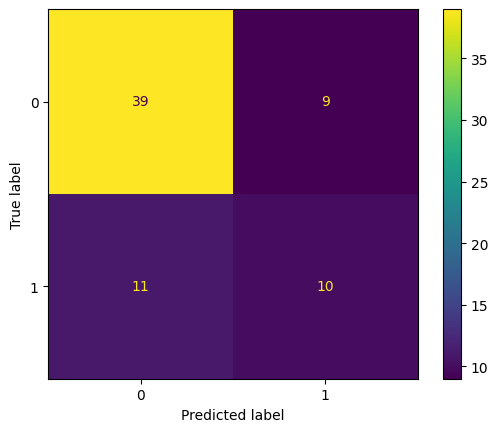

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test)
plt.show()

### Obtain performance metrics of model on the held-out test set

In [15]:
clf = gs
print('AUC: %.3f' % (roc_auc_score(y_test, clf.predict(X_test))))
print('MCC: %.3f' % (matthews_corrcoef(y_test, clf.predict(X_test))))
print('Kappa: %.3f' % (cohen_kappa_score(y_test, clf.predict(X_test))))
print('F1: %.3f' % (f1_score(y_test, clf.predict(X_test))))
print('Accuracy: %.3f' % (accuracy_score(y_test, clf.predict(X_test))))
print('Sensitivity: %.3f' % (recall_score(y_test, clf.predict(X_test))))
print('Specificity: %.3f' % (recall_score(y_test, clf.predict(X_test), pos_label=0)))
print('PPV: %.3f' % (precision_score(y_test, clf.predict(X_test))))
print('NPV: %.3f' % (precision_score(y_test, clf.predict(X_test), pos_label=0)))
print('BalancedAcc: %.3f\n\n' % (balanced_accuracy_score(y_test, clf.predict(X_test))))

AUC: 0.644
MCC: 0.297
Kappa: 0.297
F1: 0.500
Accuracy: 0.710
Sensitivity: 0.476
Specificity: 0.812
PPV: 0.526
NPV: 0.780
BalancedAcc: 0.644




## Assess final model calibration

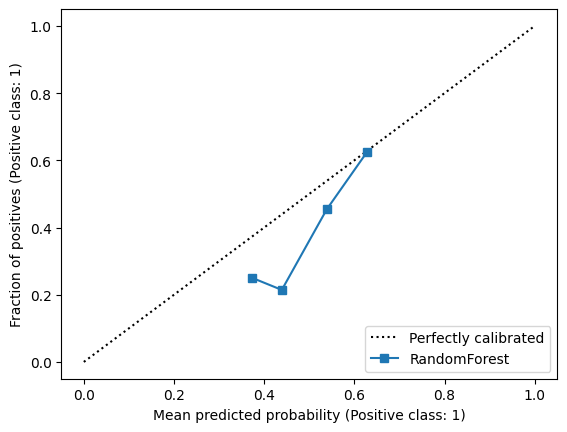

In [16]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=selected_model,
    )

# Perform Classifier Calibration

Even though we are working with <<1000 samples, which tends to produce overfitted results, and, since the `sigmoid` corresponds to Platt’s method (i.e. a logistic regression model) and the `isotonic` is a non-parametric approach we have opted by later

We also have a small dataset which prevent us from having a dataset specific for calibration to then use the `cv='prefit'` option, so here we demonstrate the calibration performed on the `X_train`, `y_train`


In [17]:
cal_clf = CalibratedClassifierCV(clf, method="isotonic", cv=5)
cal_clf.fit(X_train, y_train)

/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosantinha/miniconda3/envs/RadiomicsEssentials/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

CalibratedClassifierCV(cv=5,
                       estimator=GridSearchCV(cv=5,
                                              estimator=Pipeline(steps=[('standardscaler',
                                                                         StandardScaler()),
                                                                        ('variancethreshold',
                                                                         VarianceThreshold()),
                                                                        ('randomforestclassifier',
                                                                         RandomForestClassifier(class_weight='balanced_subsample',
                                                                                                n_jobs=-1,
                                                                                                random_state=1))]),
                                              n_jobs=-1,
                                              param_grid={'randomforestclassifier__max_depth': [1,
                                                                                                2,
                                                                                                3,
                                                                                                4,
                                                                                                5,
                                                                                                6,
                                                                                                7,
                                                                                                8,
                                                                                                9,
                                                                                                1...
                                                                                                   512,
                                                                                                   1024]},
                                              refit='AUC',
                                              scoring={'AUC': 'roc_auc',
                                                       'Accuracy': 'accuracy',
                                                       'BalancedAcc': 'balanced_accuracy',
                                                       'F1': 'f1',
                                                       'Kappa': make_scorer(cohen_kappa_score),
                                                       'MCC': make_scorer(matthews_corrcoef),
                                                       'NPV': make_scorer(precision_score, pos_label=0),
                                                       'PPV': 'precision',
                                                       'Sensitivity': 'recall',
                                                       'Specificity': make_scorer(recall_score, pos_label=0)}),
                       method='isotonic')

And now we verify if the calibration process has improved.

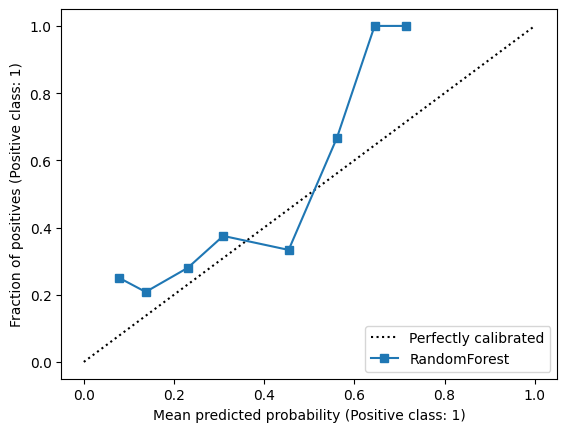

In [18]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
display = CalibrationDisplay.from_estimator(
        cal_clf,
        X_test,
        y_test,
        n_bins=10,
        name=selected_model,
    )

The outcome is still an uncalibrated model. As many of the assumptions of the used methods are not met a possible solution would be to try conformal prediction.

## Shap Analysis for model explainability

Taking into account that the best model (when comparing SVM, Logistic Regression, and Random Forest) was Random Forest we have created the following example demonstrating the use of shap for a Random Forest classifier. 

#### **If running other non-tree-based or non-Random Forest algorithms this will likely result in error during execution. As such you may need to adapt the following code for other types of classifiers**

First we need to separate our classifier from the preprocessing done using `Pipeline`.

In [19]:
from copy import deepcopy

# get preprocessing (normalized and remove near or zero variance features)
best_estimator_preprocessing_pipeline = deepcopy(gs.best_estimator_)
best_estimator_preprocessing_pipeline.steps.pop(2)

# get classifier
model = gs.best_estimator_.steps[2][1]

Transform the training dataset using the preprocessing pipeline without running the classifier

In [20]:
X_transformed = pd.DataFrame(best_estimator_preprocessing_pipeline.transform(X_train), columns=gs.best_estimator_.steps[1][1].get_feature_names_out())


### Use shap's `TreeExplainer` to obtain the feature importance according to shap analysis

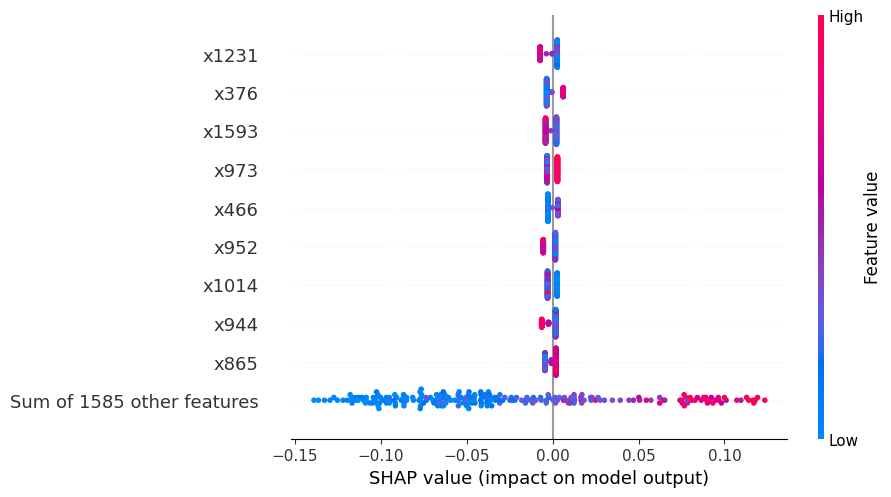

In [21]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_transformed)
shap.plots.beeswarm(shap_values[:,:,1])

# Radiomic Feature Maps - understanding model outputs

Download one positive and one negative case and the parameter map for voxel extraction.

In [ ]:
!python -c "import radiomics" || pip install --progress-bar off -q pyradiomics
!python -c "import gdown" || pip install --progress-bar off -q gdown

In [ ]:
!gdown --id 1dNqdVsN0PlCG01sl6wUCh9QJ5NnkOrDS -q
!gdown --id 12VOQCPFK4HARrwQzbB4fr_f2PepGPFWm -q
!gdown --id 1dNqdVsN0PlCG01sl6wUCh9QJ5NnkOrDS -q
!gdown --id 12VOQCPFK4HARrwQzbB4fr_f2PepGPFWm -q

In [235]:
!pyradiomics input_t2w_voxel.csv -out_dir  -f csv -p Params_T2_BW_voxel.yaml --mode voxel

Open these images in ITK-SNAP, 3D Slicer to observe the differences

The overlay of the Radiomic Maps of the previous example should give you this when overlaid to the corresponding T2w images 
![](https://drive.google.com/uc?id=1QgmtLbjT2AdwqXhUtUM--BJ3HfgxIJAZ)

# Additional Notes and Resources

- F1-score vs Balanced Accuracy - https://stats.stackexchange.com/questions/49579/balanced-accuracy-vs-f-1-score


> 1.   If N >> P, F1-score is a better.
> 2.   If P >> N, Balanced Accuracy is better.
> 
> N - number of cases in the negative class;
> P - number of cases in the positive class

- Upsampling/Downsampling - https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data

> "For up-/downsampling: I think there is no canonical answer to "if those are required". They are more one way of adapting your problem. Technically: yes, you could use them, but use them with care, especially upsampling (you might end up creating unrealistic samples without noticing it) - and be aware that changing the frequency of samples of both classes to something not realistic "in the wild" might have negative effects on prediction performance as well. At least the final, held-out test set should reflect the real-life frequency of samples again. Bottom line: I've seen both cases where doing and not doing up-/or downsampling resulted in the better final outcomes, so this is something you might need to try out (but don't manipulate your test set(s)!)."

- The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation 
> https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7 

- Why Cohen’s Kappa should be avoided as performance measure in classification 
> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916

- How to chose your classifier from a set of possible options:
> - Raschka S, Mirjalili V. **Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2**. 2019. Packt Publishing.
> - Varma S, Simon R. **Bias in error estimation when using cross-validation for model selection**. BMC bioinformatics. 2006 Dec 1;7(1):91.